# HW 6 10.14

Goal:

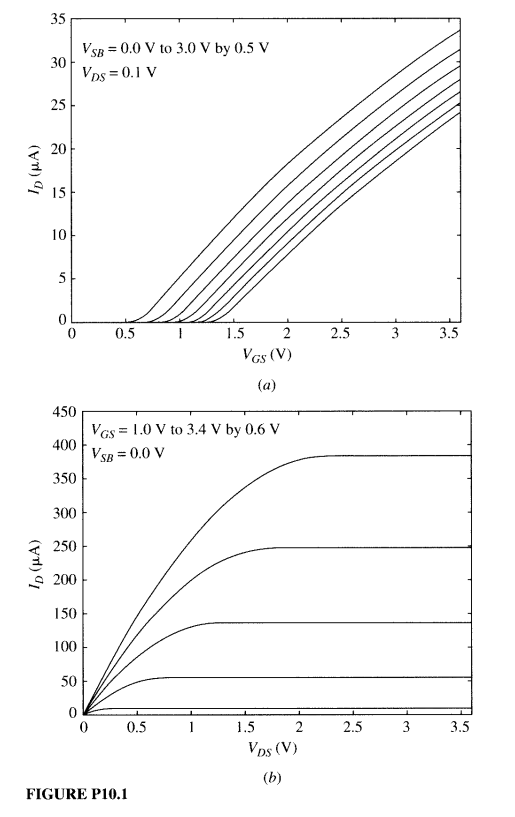

In [ ]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar, curve_fit
import os

In [ ]:
# assumed good
Kn = 450e-6
Na = 7e17 * 1e6 # cm^-3 to m^-3
tox = 10.5e-9
ni = 1e10 * 1e6 # cm^-3
q = 1.602e-19 # C
Es = 11.7 * 8.854e-12 # F/m
Eox = 3.9 * 8.854e-12 # F/m
Cox = Eox/tox # F/m^2
k = 1.38e-23 # J/K
T = 300 # K
phiT = k*T/q
print(f"phiT: {phiT:.3f} V")
phiF = phiT * np.log(Na/ni)
print(f"phiF: {phiF:.3f} V")

thetaB = 0
W = 25e-6
L = 25e-6
# must solve for 
# µ, VT0, gamma, alpha, phi0 and theta

phiT: 0.026 V
phiF: 0.467 V


In [ ]:
import pandas as pd
from pathlib import Path

# --- ID-VGS sweeps ---
input_file = "W25000_L25000_idvg.data"
outdir_vgs = Path("MOSdata/ID-VGS")
outdir_vgs.mkdir(parents=True, exist_ok=True)

df_vg = pd.read_csv(input_file, delim_whitespace=True, comment='#')

# Keep only rows where VDS == 0.1
df_vg = df_vg.loc[df_vg['VDS'].round(3) == 0.1]

for vsb in sorted(df_vg['VSB'].unique()):
    subset = df_vg.loc[df_vg['VSB'] == vsb, ['VGS', 'IDS']]
    fname = outdir_vgs / f"{int(vsb * 10):02d}.csv"
    subset.to_csv(fname, index=False)
    print(f"Saved {fname} ({len(subset)} rows, VDS=0.1 check passed)")


# --- ID-VDS sweeps ---
input_file = "W25000_L25000_idvd.data"
outdir_vds = Path("MOSdata/ID-VDS")
outdir_vds.mkdir(parents=True, exist_ok=True)

df_vd = pd.read_csv(input_file, delim_whitespace=True, comment='#')

# Keep only rows where VSB == 0
df_vd = df_vd.loc[df_vd['VSB'].round(3) == 0]

for vgs in sorted(df_vd['VGS'].unique()):
    subset = df_vd.loc[df_vd['VGS'] == vgs, ['VDS', 'IDS']]
    fname = outdir_vds / f"{int(vgs * 10):02d}.csv"
    subset.to_csv(fname, index=False)
    print(f"Saved {fname} ({len(subset)} rows, VSB=0 check passed)")


Saved MOSdata\ID-VGS\00.csv (73 rows, VDS=0.1 check passed)
Saved MOSdata\ID-VGS\05.csv (73 rows, VDS=0.1 check passed)
Saved MOSdata\ID-VGS\10.csv (73 rows, VDS=0.1 check passed)
Saved MOSdata\ID-VGS\15.csv (73 rows, VDS=0.1 check passed)
Saved MOSdata\ID-VGS\20.csv (73 rows, VDS=0.1 check passed)
Saved MOSdata\ID-VGS\25.csv (73 rows, VDS=0.1 check passed)
Saved MOSdata\ID-VGS\30.csv (73 rows, VDS=0.1 check passed)
Saved MOSdata\ID-VDS\10.csv (37 rows, VSB=0 check passed)
Saved MOSdata\ID-VDS\16.csv (37 rows, VSB=0 check passed)
Saved MOSdata\ID-VDS\22.csv (37 rows, VSB=0 check passed)
Saved MOSdata\ID-VDS\28.csv (37 rows, VSB=0 check passed)
Saved MOSdata\ID-VDS\34.csv (37 rows, VSB=0 check passed)


C:\Users\kaden\AppData\Local\Temp\ipykernel_35368\3883613107.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_vg = pd.read_csv(input_file, delim_whitespace=True, comment='#')
C:\Users\kaden\AppData\Local\Temp\ipykernel_35368\3883613107.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_vd = pd.read_csv(input_file, delim_whitespace=True, comment='#')


Vt0: 0.6313131313131313 V
Initial phi0 guess: 1.0628587267422778 V
phi0* = 0.616057 V
gamma: 0.637172 V^0.5
VFB: -0.484672 V


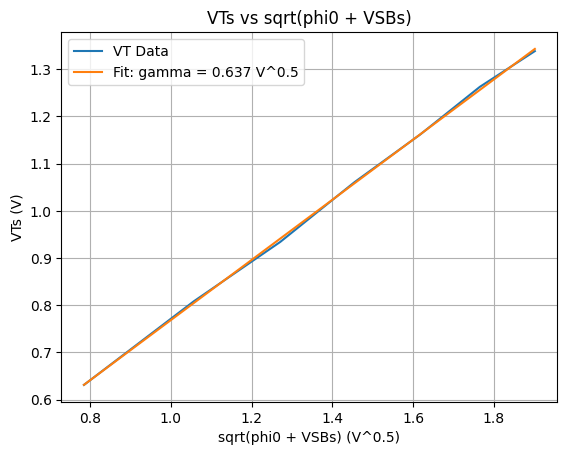

[0.03968134 0.03948399 0.03928678 0.03908984 0.03889333 0.03869738
 0.03850203 0.03830743 0.03811364 0.03792073 0.03772879 0.03753783
 0.03734796 0.03715915 0.03697151 0.03678503 0.03659977 0.03641572
 0.03623293 0.03605141 0.03587118 0.03569224 0.03551463 0.03533832
 0.03516334 0.03498969 0.03481736 0.03464638 0.03447674]
u0*: 0.047847 m^2/Vs
theta*: 0.130072 V^-1
alpha*: 1.14032 V^-1
Refined u0*: 0.0510346 m^2/Vs
Refined theta*: 0.151984 V^-1
Refined alpha : 1.1687520849233484
0.06528688222310644
thetaB*: 0.0652869 V^-1


In [ ]:
# approach: use ID-VGS data to determine Vt0 gamma and phi-0, then use ID-VGS (VSB = 0) to determine u0 and theta, then ID-VDS to determine alpha

################################### FIND VT0 #################################
def find_vt(file):

    data = np.loadtxt(file, delimiter=',', skiprows=1)
    VGS = data[:, 0]
    ID = data[:, 1]

    # take data close to intercept
    mask = (ID > 5e-6) & (ID < 10e-6)
    VSB_fit = VGS[mask]
    ID_fit = ID[mask]

    # linearize this line
    slope, intercept = np.polyfit(VSB_fit, ID_fit, 1)
    VSB_fit = np.linspace(0, 2.5, 100)
    ID_fit = slope * VSB_fit + intercept
    # print(f"slope: {slope}, intercept: {intercept}")

    # find index where ID = 0
    idx = np.where(ID_fit >= 0)[0][0]
    Vt = VSB_fit[idx]
    return Vt, VSB_fit, ID_fit

Vt0, VSBs_fit0, ID_fit0 = find_vt("MOSdata/ID-VGS/00.csv")

print(f"Vt0: {Vt0} V")

################################### FIND VTs of the rest #################################

VTs = [Vt0]
VSBs = [0.0]

for file in os.listdir("MOSdata/ID-VGS"):
    if file.endswith(".csv") and file != "0.csv":
        Vt, VGS_fit, ID_fit = find_vt(os.path.join("MOSdata/ID-VGS", file))
        VSB = float(file.split(".csv")[0]) * 0.1
        # print(f"VSB: {VSB} V, Vt: {Vt} V")
        # add all to array
        VTs.append(Vt)
        VSBs.append(VSB)

#################### extrapolate gamma and phi0 from VTs and VGs ###########################
VTs = np.array(VTs)
VSBs = np.array(VSBs)

# guess 
phi0 = 2*phiF + 5*phiT
print(f"Initial phi0 guess: {phi0} V")
# phi0 = 
X_array = np.sqrt(phi0 + VSBs)


eps = 1e-12
phi0_min = -np.min(VSBs) + eps  # ensure positive

# create function to minimize
def sse_for_phi0(phi0):
    if np.any(phi0 + VSBs <= 0):
        return np.inf
    x = np.sqrt(phi0 + VSBs)
    X = np.column_stack([np.ones_like(x), x])
    beta, *_ = np.linalg.lstsq(X, VTs, rcond=None)
    resid = VTs - X @ beta
    return np.sum(resid**2)

# use scipy minimize scalar to minimize the sum of squares error function
res = minimize_scalar(sse_for_phi0, bounds=(phi0_min, phi0_min + 1e6), method='bounded',options={'xatol':1e-9})
phi0_opt = res.x
phi0 = phi0_opt
print(f"phi0* = {phi0_opt:.6g} V")

X_array = np.sqrt(phi0_opt + VSBs)


plt.plot(X_array, VTs, label = "VT Data")
plt.title("VTs vs sqrt(phi0 + VSBs)")
plt.xlabel("sqrt(phi0 + VSBs) (V^0.5)")
plt.ylabel("VTs (V)")
plt.grid()

# find the slope of the line to get gamma
slope, intercept = np.polyfit(X_array, VTs, 1)
gamma = slope
print(f"gamma: {gamma:.6g} V^0.5")
plt.plot(X_array, intercept + slope * X_array, label=f"Fit: gamma = {gamma:.3f} V^0.5")

VFB = np.average(VTs - phi0 - gamma*X_array)
print(f"VFB: {VFB:.6g} V")

plt.legend()
plt.show()

# 

################################### estimate u0 and theta  ################################# 
# estimate u0 and theta assuming alpha/2 VDS^2 is negligible

# solving for ueff first
def get_VT(Vsb):
    return VFB + phi0 + gamma*np.sqrt(phi0 + Vsb)

def Idsn_noalpha(ueff, VGS, Vsb, Vds):
    # we are assuming non-saturation here, so we should only use data where VGS - VT > 0.1 V
    return (W/L) * ueff * Cox * ((VGS - get_VT(Vsb))*Vds)

def get_ueff(Id, Vgs, Vsb, Vds):
    return Id / ((W/L) * Cox * ((Vgs - get_VT(Vsb))*Vds))

# using VSB = 0, load file and get ueffs
data = np.loadtxt(("MOSdata/ID-VGS/00.csv"), delimiter=",", skiprows=1)
VGS = data[:, 0]
ID = data[:, 1]
# we need to only use data in non-saturation, so lets mask the data
theta_mask = ID > 2e-5
VGS_fit = VGS[theta_mask]
VGS_fit_save = VGS_fit
ID_fit = ID[theta_mask]
ueffs = get_ueff(ID_fit, VGS_fit, 0.0, 0.1)
print(ueffs)
ueffs_data = ueffs # saving this to plot later

# now lets curve fit ueffs to get u0 and theta
def ueff_from_theta_u0(Vgs, Vsb, u0, theta):
    return u0 / (1 + theta * (Vgs - get_VT(Vsb)))

func = lambda vgs, u0, theta: ueff_from_theta_u0(vgs, 0.0, u0, theta)
popt, pcov = curve_fit(func, VGS_fit, ueffs, p0=[300e-6 * 1e4, 0.1], bounds=([0, 0.01], [np.inf, np.inf]))
u0_opt, theta_opt = popt

init_values = popt
print(f"u0*: {u0_opt:.6g} m^2/Vs")
print(f"theta*: {theta_opt:.6g} V^-1")


# ################################### determine alpha using ID-VDS data #################################


def Vds_prime(Vgs, Vt, alpha):
    return (Vgs - Vt) / alpha

def Idsn_withalpha(ueff, VGS, Vsb, Vds, alpha):
    return (W/L) * ueff * Cox * (max((VGS - get_VT(Vsb)), 0)*Vds - (alpha/2)*Vds**2)

def get_alpha():
    
    # load ID-VDS data
    data = np.loadtxt(("MOSdata/ID-VDS/34.csv"), delimiter=",", skiprows=1)
    VGS = 3.4
    VDS = data[:, 0]
    ID = data[:, 1]
    # we need to only use data in non-saturation, so lets mask the data
    # assume alpha = 2 so we dont curve fit improperly
    mask = (VDS < Vds_prime(VGS, Vt0, 1)) & (VDS > 0.25)
    VDS_fit = VDS[mask]
    ID_fit = ID[mask]
    ueff = ueff_from_theta_u0(VGS, 0.0, u0_opt, theta_opt)

    # curve fit to get alpha
    def fit_func(vds, alpha):
        return Idsn_withalpha(ueff, VGS, 0.0, vds, alpha)

    popt, pcov = curve_fit(fit_func, VDS_fit, ID_fit, p0=[0.1], bounds=([0], [np.inf]))
    alpha_opt = popt[0]
    return alpha_opt

alpha_opt = get_alpha()
print(f"alpha*: {alpha_opt:.6g} V^-1")


############################ Refine u0 and theta now using alpha ############################

# curve fit ueffs based on alpha
def get_ueff_withalpha(Id, Vgs, Vsb, Vds, alpha):
    return Id / ((W/L) * Cox * (max((Vgs - get_VT(Vsb)), 0)*Vds - (alpha/2)*Vds**2))

def refine_u0_theta(u0, theta, file="MOSdata/ID-VGS/00.csv"):
    # using VSB = 0, load file and get ueffs
    data = np.loadtxt((file), delimiter=",", skiprows=1)
    VGS = data[:, 0]
    ID = data[:, 1]
    # we need to only use data in non-saturation, so lets mask the data
    
    VGS_fit = VGS[theta_mask]
    ID_fit = ID[theta_mask]
    Vsb = float(Path(file).stem) * 0.1
    ueffs = []
    for vgs, id in zip(VGS_fit, ID_fit):
        vds = min(0.1, Vds_prime(vgs, get_VT(Vsb), alpha_opt))
        vds = 0.1
        ueff = get_ueff_withalpha(id, vgs, Vsb, vds, alpha_opt)
        ueffs = np.append(ueffs, ueff)

    # now curve fit ueffs to get u0 and theta
    func = lambda vgs, u0, theta: ueff_from_theta_u0(vgs, Vsb, u0, theta)
    # print(np.size(VGS_fit), np.size(ueffs))
    popt, pcov = curve_fit(func, VGS_fit, ueffs, p0=[u0, theta], bounds=([0, 0.005], [np.inf, np.inf]))
    u0_opt, theta_opt = popt
    return u0_opt, theta_opt

# lets just run this optimization many times to improve values
file = os.listdir(dir := "MOSdata/ID-VGS")[0]
# for file in os.listdir(dir := "MOSdata/ID-VGS"):
for i in range(10):
    u0_opt, theta_opt = refine_u0_theta(u0_opt, theta_opt, file=os.path.join(dir, file))
    alpha_opt = get_alpha()


print(f"Refined u0*: {u0_opt:.6g} m^2/Vs")
print(f"Refined theta*: {theta_opt:.6g} V^-1")

print(f"Refined alpha : {alpha_opt}")

################ Calculate thetaB to match #######################################
vsbs = []
Ids = []
# extract ueff from each Id/Vgb plot @ the same Vgs.
for filename in os.listdir("MOSdata/ID-VGS"):
    if filename.endswith(".csv"):
        data = np.loadtxt(os.path.join("MOSdata/ID-VGS", filename), delimiter=",", skiprows=1)
        VGS = data[:, 0] # we only need Vgs =3.6
        ID = data[:, 1]
        Vsb = float(Path(filename).stem) * 0.1
        vsbs.append(Vsb)
        Ids.append(ID[-1])

# get ueffs
ueffs = []
for vsb, id in zip(vsbs, Ids):
    ueffs.append(get_ueff_withalpha(id, 3.6, vsb, 0.1, alpha_opt))

# now lets curve fit ueffs to get u0 and theta
def ueff_from_thetaB(Vgs, Vsb, u0, theta, thetaB):
    return u0 / (1 + theta * (Vgs - get_VT(Vsb)) + thetaB*Vsb)

func = lambda Vsb, thetaB: ueff_from_thetaB(3.6, Vsb, u0_opt, theta_opt, thetaB)
popt, pcov = curve_fit(func, vsbs, ueffs)
thetaB = popt[0]
print(thetaB)
print(f"thetaB*: {thetaB:.6g} V^-1")
###################################################################################################



def Idssat(ueff, Vgs, Vt, alpha):
    return (W/L)*ueff*Cox*(max(0, (Vgs-Vt))**2) / (2*alpha)
# plot our model based on values found





VT0: 0.6314965629402916
Gamma: 0.6371717314685383
u0 : 0.05103459908276327
alpha: 1.1687520849233484
phi0: 0.6160566214373551
theta: 0.15198403877969083
thetaB: 0.06528688222310644


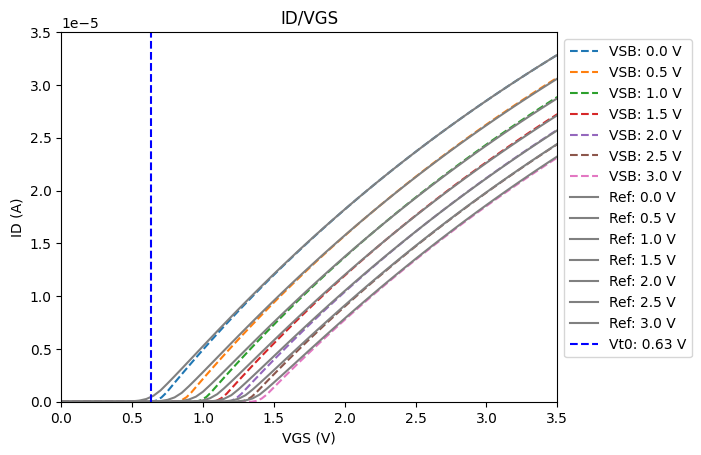

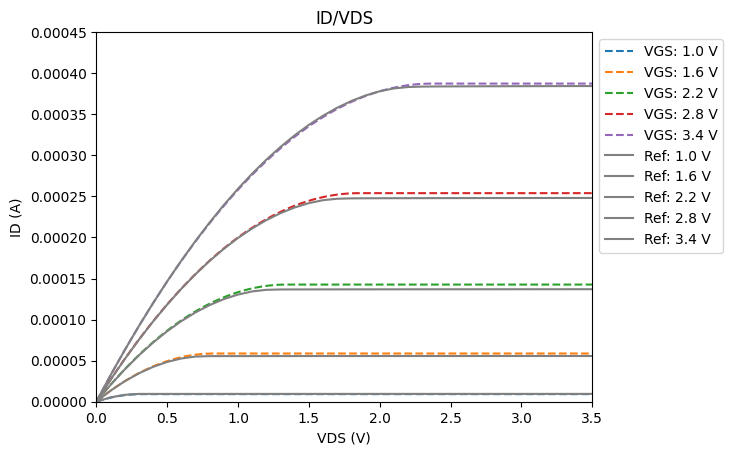

In [ ]:
# gamma = 0.6371
# gamma = 0.8
def model(Vgs, Vsb, Vds):
    ueff = ueff_from_thetaB(Vgs, Vsb, u0_opt, theta_opt, thetaB)
    Vt  = get_VT(Vsb)
    vdsp = Vds_prime(Vgs, Vt, alpha_opt)
    if Vds < vdsp:
        id = Idsn_withalpha(ueff, Vgs, Vsb, Vds, alpha_opt)
    else:
        id = Idssat(ueff, Vgs, Vt, alpha_opt)
    return id
VSBs = np.linspace(0, 3.0, 7)
VGSs = np.linspace(0, 3.5, 100)



print(f"VT0: {get_VT(0)}")
print(f"Gamma: {gamma}")
print(f"u0 : {u0_opt}")
print(f"alpha: {alpha_opt}")
print(f"phi0: {phi0}")
print(f"theta: {theta_opt}")
print(f"thetaB: {thetaB}")

for VSB in VSBs:
    IDs = []
    for VGS in VGSs:
        ID = model(VGS, VSB, 0.1)
        IDs.append(ID)
    plt.plot(VGSs, IDs, label=f'VSB: {VSB:.1f} V', linestyle='--')


# iterate through csvs in MOSdata folder and plot data
for filename in os.listdir("MOSdata/ID-VGS"):
    if filename.endswith(".csv"):
        data = np.loadtxt(os.path.join("MOSdata/ID-VGS", filename), delimiter=",", skiprows=1)
        VGS = data[:, 0]
        ID = data[:, 1]
        plt.plot(VGS, ID, label="Ref: " + str(float(filename[:-4]) * 0.1) + " V" , color='grey')

# plt.plot(VSBs_fit0, ID_fit0, label='Fit', color='red', linestyle='--')
plt.axvline(x=Vt0, color='blue', linestyle='--', label=f'Vt0: {Vt0:.2f} V')


plt.xlim(0, 3.5)
plt.ylim(0, 35e-6)
plt.title("ID/VGS")
plt.xlabel("VGS (V)")
plt.ylabel("ID (A)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # moves legend outside
plt.show()


# plot ID-VDS data with model
VDSs = np.linspace(0, 3.5, 100)
VGSs = np.linspace(1.0, 3.4, 5)
for VGS in VGSs:
    IDs = []
    for VDS in VDSs:
        ID = model(VGS, 0.0, VDS)
        IDs.append(ID)
    plt.plot(VDSs, IDs, label=f'VGS: {VGS:.1f} V', linestyle='--')

for filename in os.listdir("MOSdata/ID-VDS"):
    if filename.endswith(".csv"):
        data = np.loadtxt(os.path.join("MOSdata/ID-VDS", filename), delimiter=",", skiprows=1)
        VDS = data[:, 0]
        ID = data[:, 1]
        plt.plot(VDS, ID, label="Ref: " + str(round(float(filename[:-4]) * 0.1, 2)) + " V" , color='grey')

plt.xlim(0,3.5)
plt.ylim(0, 450e-6)
plt.title("ID/VDS")
plt.xlabel("VDS (V)")
plt.ylabel("ID (A)")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  # moves legend outside
plt.show()
